## HDR Tutorial - Phenotype Computation
- Tutors: Minhong Wang, Honghan Wu, Debbie Wake
- University of Edinburgh
- March 2021

## Summary
This tutorial illustrates the streamlined pipeline of applying health data science on routine data for research.

## Table of Content
1. Type 2 Diabetes by Diagnosis
2. Type 2 Diabetes by Lab Test Results
3. Drug episodes


## Phenotype definitions for Type 2 Diabetes

### Load the packages
If the packages are installed already, then you can skip this step and load the libraries directly.

In [10]:
install.packages("RPostgres")
install.packages("DBI")
install.packages("ggplot2")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [1]:
# load the libraries needed for this tutorial
library(RPostgres)
library(DBI)

### Connect to the database
Based on the tables we generated in the previous section, we prepared the database (called `tutorial`) of the Common Data Model in PostgreSQL.

The SQL scripts for creating the Common Data Model can be find here: <https://github.com/OHDSI/CommonDataModel/tree/master/PostgreSQL>

A summary of the steps of creating an instantiation of the Common Data Model:
- Create an empty schema
- Create the tables and fields
- Load the data into the schema
- Add the set of indexes and primary keys
- Add the constraints (foreign keys)

Here, we access the database we prepared from R.

In [6]:
# connect to the database

pw <- {
  "tutorial"
}

con <- dbConnect(RPostgres::Postgres(),
                 host = 'postgres',   
                 port = 5432,
                 dbname = 'tutorial',
                 user = 'postgres',
                 password = pw)

# test the connection, list all the tables
dbListTables(con)

[1] "concept"               "concept_relationship"  "attribute_definition" 
 [4] "cdm_source"            "metadata"              "vocabulary"           
 [7] "domain"                "concept_class"         "relationship"         
[10] "concept_synonym"       "drug_exposure"         "device_exposure"      
[13] "location"              "provider"              "care_site"            
[16] "observation"           "fact_relationship"     "location_history"     
[19] "survey_conduct"        "concept_ancestor"      "source_to_concept_map"
[22] "person"                "drug_strength"         "observation_period"   
[25] "specimen"              "visit_occurrence"      "visit_detail"         
[28] "procedure_occurrence"  "condition_occurrence"  "measurement"          
[31] "note"                  "note_nlp"              "payer_plan_period"    
[34] "cost"                  "drug_era"              "dose_era"             
[37] "condition_era"

The tables we use for this tutorials are:
- concept: a reference table
- person: demographic data
- visit_occurrence: adminission data
- condition_occurrence: diagnosis
- drug_exposure: drug
- measurement: lab tests

### SQL query
After connecting to the database, we can use SQL scripts to query the patients data. 
- The`SELECT` statement retrieves data from a datase. Use `SELECT *` to select all columns. For example

`SELECT column1, column 2,...
 FROM table_name;`

- The `WHERE` clause is used to filter records. It is used to extract only those records that fulfill a specific condition.

In [7]:
# retrieve all the records from the table person with the condition gender concept id = 1
query1 <- "SELECT *
            FROM person
            WHERE gender_concept_id = 1"
result1 <- dbGetQuery(con, query1)
head(result1)

,person_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,birth_datetime,death_datetime,race_concept_id,ethnicity_concept_id,location_id,provider_id,care_site_id,person_source_value,gender_source_value,gender_source_concept_id,race_source_value,race_source_concept_id,ethnicity_source_value,ethnicity_source_concept_id
,<int64>,<int>,<int>,<int>,<int>,<dttm>,<dttm>,<int>,<int>,<int64>,<int64>,<int64>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>
1,101913723,1,1991,NA,NA,NA,NA,3,4,NA,NA,NA,NA,NA,0,NA,0,NA,0
2,102355828,1,1935,NA,NA,NA,NA,3,4,NA,NA,NA,NA,NA,0,NA,0,NA,0
3,102722666,1,1972,NA,NA,NA,NA,3,4,NA,NA,NA,NA,NA,0,NA,0,NA,0
4,103905721,1,1990,NA,NA,NA,NA,3,4,NA,NA,NA,NA,NA,0,NA,0,NA,0
5,105921728,1,1992,NA,NA,NA,NA,3,4,NA,NA,NA,NA,NA,0,NA,0,NA,0
6,106267208,1,1926,NA,NA,NA,NA,3,4,NA,NA,NA,NA,NA,0,NA,0,NA,0


### Quiz
Can you retrieve all the records from the table condition_occurence with the condition that condition_concept_id = 1085?

Try your query in the cell below.

In [1]:
# quiz - retrieve all the records from the table condition_occurrence with the condition that condition_concept_id = 1085


### Retrieve type 2 diabetes patients based on diagnoses

We focus on secondary care data in this tutorial. According to CALIBER diabetes mellitus phenotype, we can find the ICD-10 code of diabetes here <https://www.caliberresearch.org/portal/phenotypes/diabetes>.

Here, we focus on the type 2 diabetes (non insulindependend diabetes). Hence, we want to find all patients with diagnosis coded in E11*. Three tables will be used for this query: person, condition_occurrence, and concept.

In [5]:
# the sql code for query
diabetes_condition <- "SELECT person.person_id, person.gender_concept_id, person.year_of_birth
                  FROM person, condition_occurrence, concept
                  WHERE person.person_id = condition_occurrence.person_id
                  AND condition_occurrence.condition_concept_id = concept.concept_id
                  AND concept.concept_name ~ '^E11.*'"
# for all types of diabetes: '^(E10|E11|E12|O242).*'

# store the query results in a data frame called patient_diabetes1
patient_diabetes1 <- dbGetQuery(con,diabetes_condition)
head(patient_diabetes1)

,person_id,gender_concept_id,year_of_birth
,<int64>,<int>,<int>
1,1810841405,1,1984
2,2705312717,2,1931
3,108101128,1,2010
4,212257965,1,1925
5,312245854,2,1924
6,407368314,2,1936


### Quiz
Similar to retrieve all the patients with type 2 diabetes, can you retrieve all the patients with acute myocardial infarction based on their diagnosis?

In [2]:
# quiz - e.g. retrieve the patients with acute myocardial infarction


We provide a more comprehensive query with replacing the concept id of gender by their concept names (female and male).

In [8]:
# the query with replacing the gender with characters:male/female
test2 <- "WITH person2 AS (SELECT person.person_id, concept.concept_name, person.year_of_birth
        FROM person INNER JOIN concept ON person.gender_concept_id = concept.concept_id)
        SELECT person2.person_id, person2.year_of_birth, person2.concept_name
        FROM person2, condition_occurrence, concept
        WHERE person2.person_id = condition_occurrence.person_id                  
        AND condition_occurrence.condition_concept_id = concept.concept_id
        AND concept.concept_name ~ '^E11.*'"


# store the query results in a data frame called patient_diabetes1
patient_diabetes1 <- dbGetQuery(con,test2)
head(patient_diabetes1)

,person_id,year_of_birth,concept_name
,<int64>,<int>,<chr>
1,1810841405,1984,male
2,2705312717,1931,female
3,108101128,2010,male
4,212257965,1925,male
5,312245854,1924,female
6,407368314,1936,female


## Visualisation of the demographic data in retrieved patients with type 2 diabetes based on diagnoses

In [9]:
# get a sense of the data
head(patient_diabetes1)
str(patient_diabetes1)
names(patient_diabetes1)

,person_id,year_of_birth,concept_name
,<int64>,<int>,<chr>
1,1810841405,1984,male
2,2705312717,1931,female
3,108101128,2010,male
4,212257965,1925,male
5,312245854,1924,female
6,407368314,1936,female


'data.frame':	73 obs. of  3 variables:
 $ person_id    :integer64 1810841405 2705312717 108101128 212257965 312245854 407368314 409322116 410704717 ... 
 $ year_of_birth: int  1984 1931 2010 1925 1924 1936 1932 1970 1958 1990 ...
 $ concept_name : chr  "male" "female" "male" "male" ...


[1] "person_id"     "year_of_birth" "concept_name"

### Make a histogram with Basic R
R provides `hist()` function that allow us to compute a histogram of the given data.

Here is an example of using basic R commands to generate a histogram of year of birth in patients with type 2 diabetes based on their diagnoses.

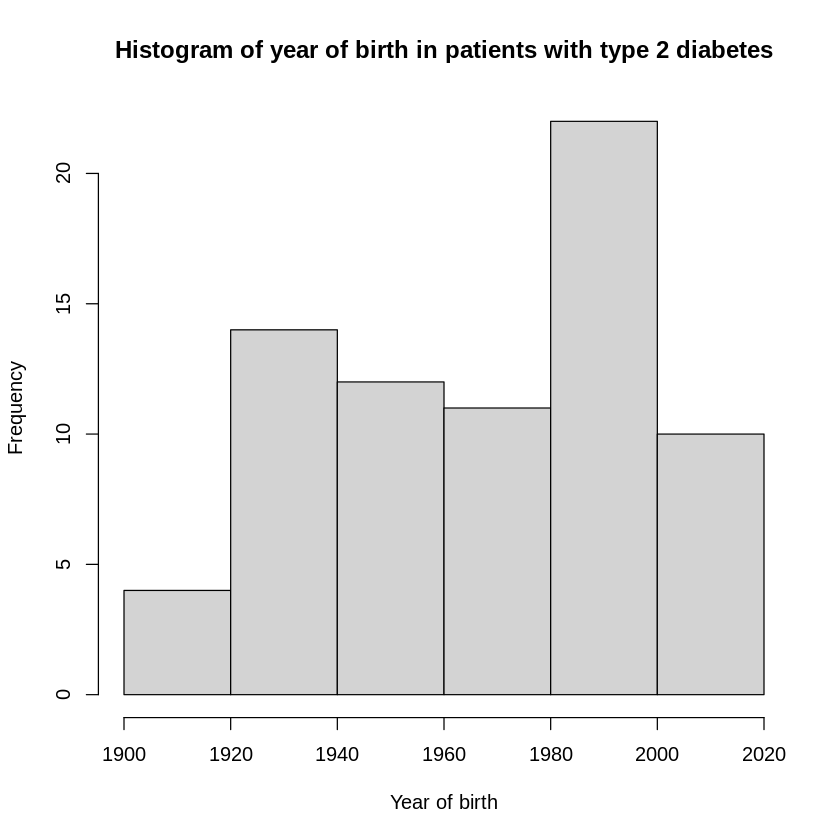

In [10]:
# basic histogram of year of birth
hist(patient_diabetes1$year_of_birth,
     breaks = 5,
     main = "Histogram of year of birth in patients with type 2 diabetes",
     xlab = "Year of birth")

### Make a histogram with `ggplot2`
In addition to R basic commands, you can also make histograms by using `ggplot2`, which is a commonly used data visualisation package for R. We already have `ggplot2` installed here. So please just load the package before using their functions.
Here we provide an example of generating a histogram with `ggplot2`.

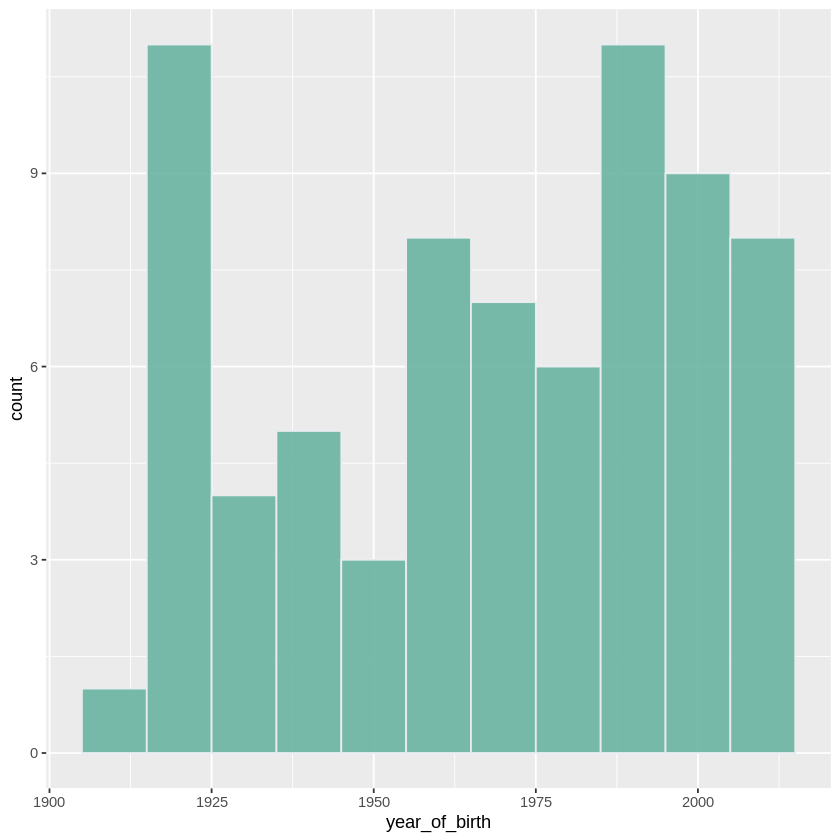

In [15]:
# using ggplot2
library(ggplot2)

ggplot(patient_diabetes1,aes(x=year_of_birth)) + 
  geom_histogram(binwidth = 10, fill="#69b3a2", color="#e9ecef", alpha=0.9)

### Generating a histogram by group
An example of generating a histogram of year of birth by grouping the patients based on their gender.

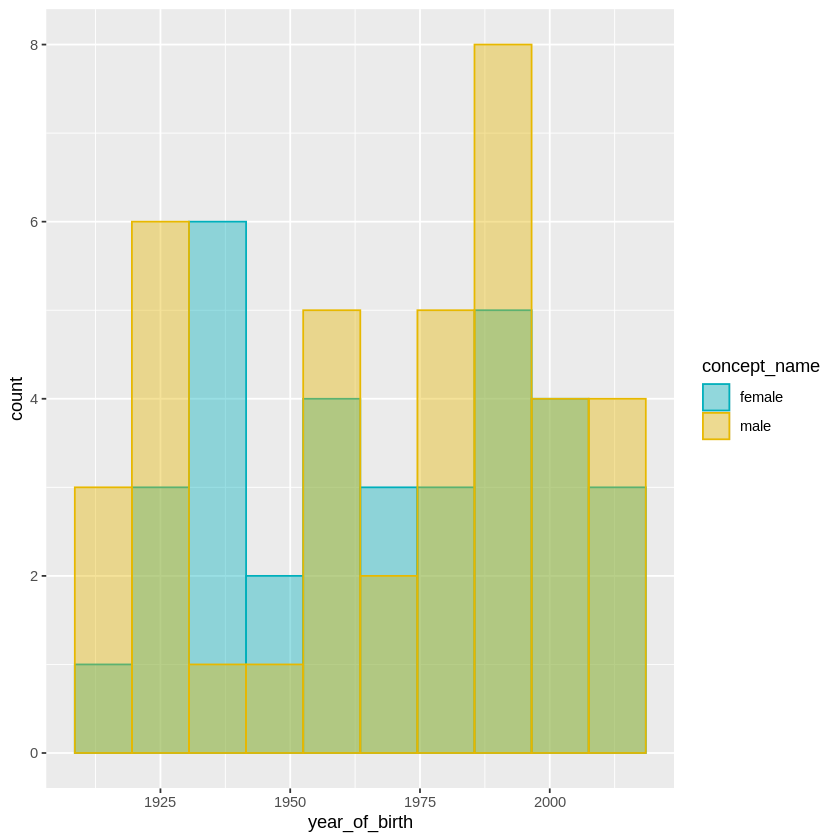

In [19]:
# histogram of year of birth with two gender groups
ggplot(patient_diabetes1, aes(x = year_of_birth)) +
    geom_histogram(aes(color = concept_name, fill = concept_name),
                  position = "identity", bins = 10, alpha = 0.4) +
    scale_color_manual(values = c("#00AFBB", "#E7B800")) +
    scale_fill_manual(values = c("#00AFBB", "#E7B800"))

### Making bar chart and pie chart with Basic R
Examples of generating bar chart and pie chart with R basic commands for visualising the gender distribution in this patient group.

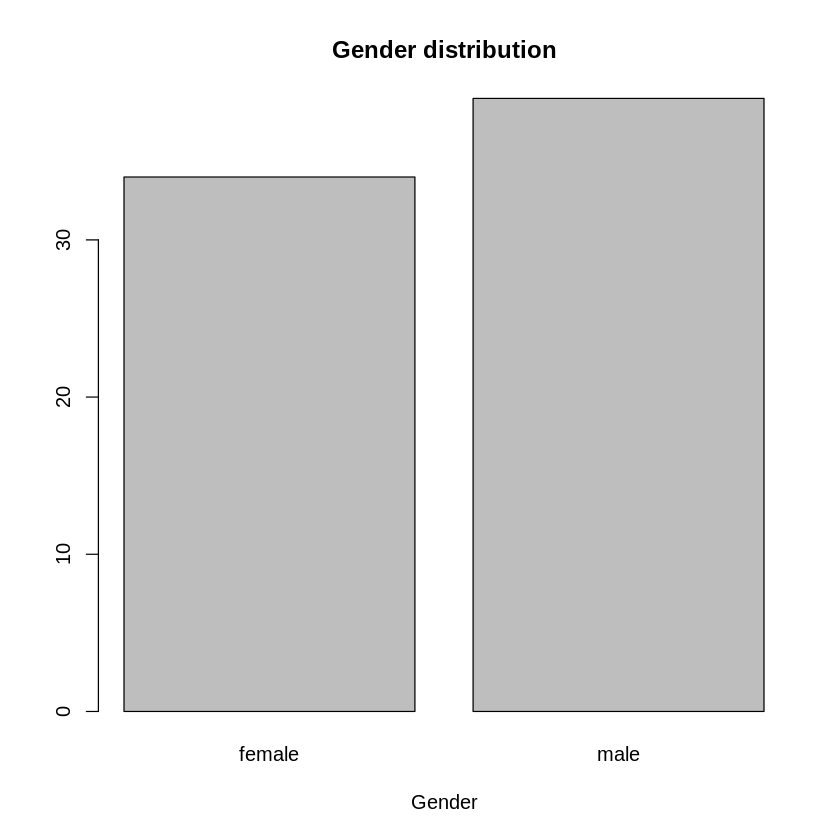

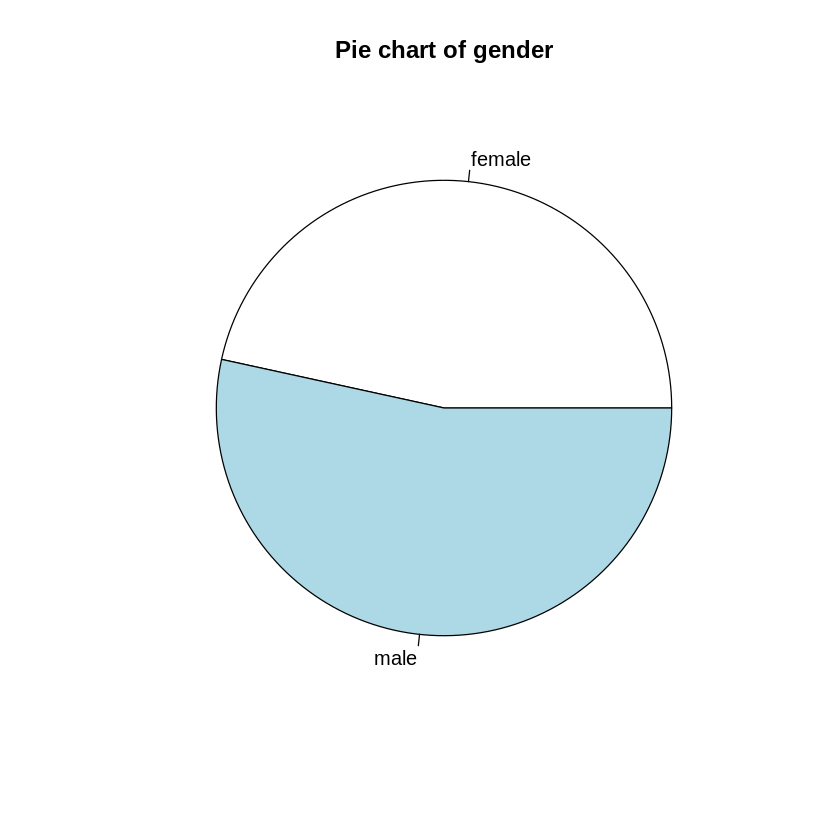

In [11]:
# visualise the gender distribution
freq <- table(patient_diabetes1$concept_name)
barplot(freq,
       main = "Gender distribution",
       xlab = "Gender")
pie(freq, main = "Pie chart of gender")

## Retrieve the patients based on test results

For example, we want to find all the patients with at least one HBA1C result value higher or equal to 7. The three tables we need for this query are person, concept, and measurement tables.

In [13]:
diabetes_lab <- "SELECT person.person_id, person.year_of_birth, measurement.value_as_number, measurement.unit_source_value
                  FROM person, measurement, concept
                  WHERE person.person_id = measurement.person_id
                  AND measurement.measurement_concept_id = concept.concept_id
                  AND concept.concept_name = 'HBA1C'
                  AND measurement.value_as_number >= 7"
# AND unit_source_value

patient_diabetes2 <- dbGetQuery(con, diabetes_lab)
head(patient_diabetes2)

,person_id,year_of_birth,value_as_number,unit_source_value
,<int64>,<int>,<dbl>,<chr>
1,407834118,1983,7.344608,NULL
2,608472726,1947,8.816821,NULL
3,1307587481,1958,8.420652,NULL
4,1712519295,1951,8.958857,NULL
5,1810262820,1926,8.655646,NULL
6,2004278627,1927,8.947153,NULL


### Quiz
Can you generate a histogram of year of birth in this group of patients?

In [3]:
# quiz - a histogram of year of birth in this group of patients?


## Quiz - Retrieve the patients based on drug exposure
Can you retrieve the patients that have been prescribed with a specific drug? For example, the concept name of this specific drug is 20030800060. 

In [5]:
# quiz - retrive the patients based on drug exposure
